In [33]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import seaborn as sns
%matplotlib inline
rcParams['figure.figsize'] = 25, 10

In [24]:
tripsfile = open('data_cleaned/trips_all_data', 'rb')
trips = pickle.load(tripsfile)
trips.head()

,TripID,Duration,StartDate,StartStation,StartTerminal,EndDate,EndStation,EndTerminal,Bike#,SubscriptionType,ZipCode
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103


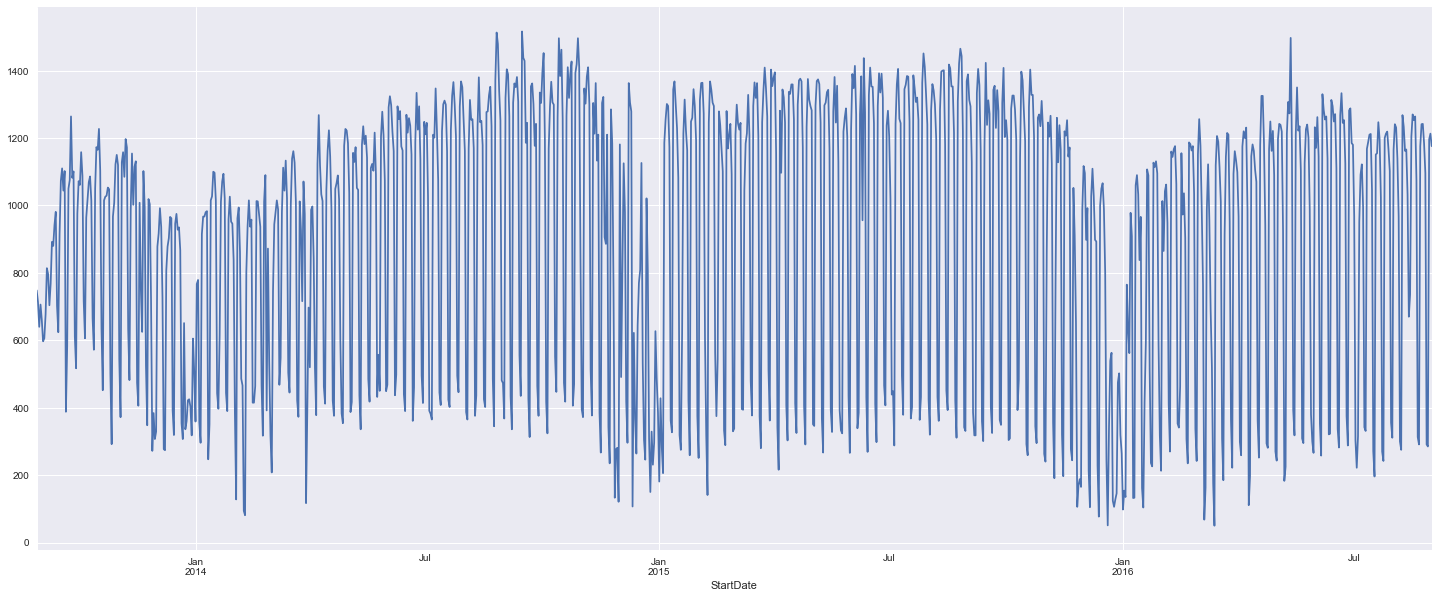

In [29]:
tDDemand = trips.set_index('StartDate')
tDDemand = tDDemand.groupby([pd.TimeGrouper(freq = 'D')]).size()
#tDDemand = tDDemand.stack().reset_index('StartStation')
tDDemand = tDDemand.rename('Demand')
tDDemand.plot(figsize=(25,10))

In [30]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center = False).mean()
    rolstd = timeseries.rolling(window=12, center = False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

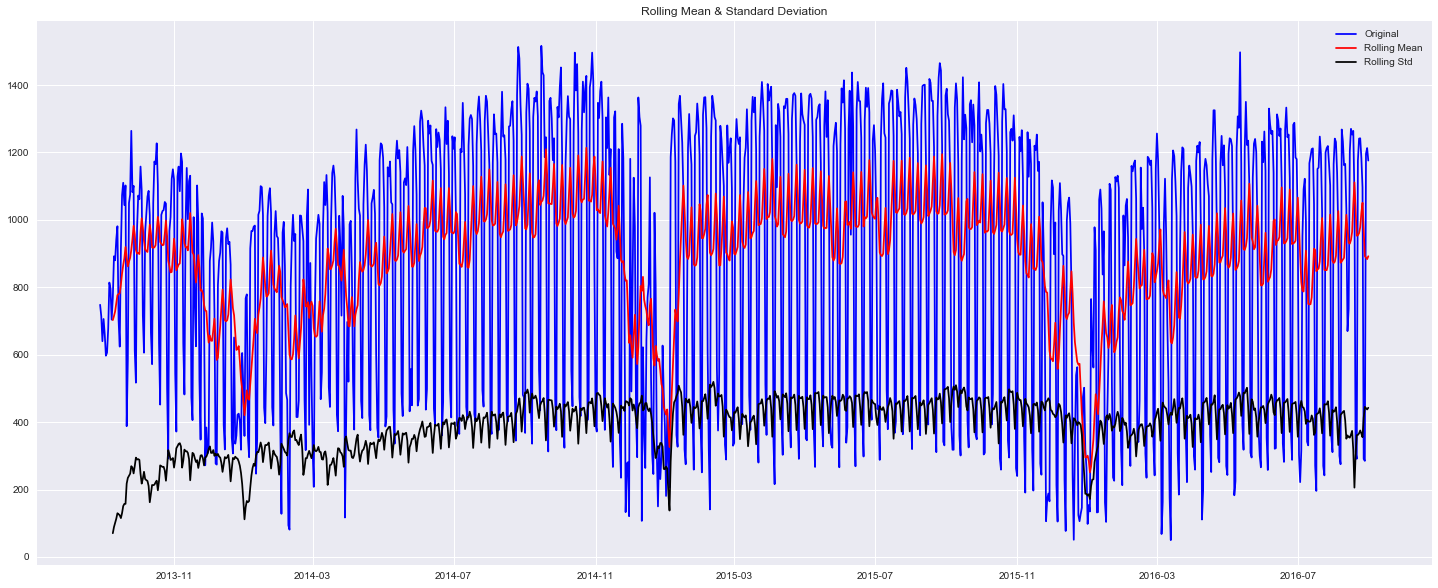

Results of Dickey-Fuller Test:
Test Statistic                   -3.422423
p-value                           0.010218
#Lags Used                       21.000000
Number of Observations Used    1077.000000
Critical Value (1%)              -3.436436
Critical Value (5%)              -2.864227
Critical Value (10%)             -2.568201
dtype: float64


In [34]:
test_stationarity(tDDemand)

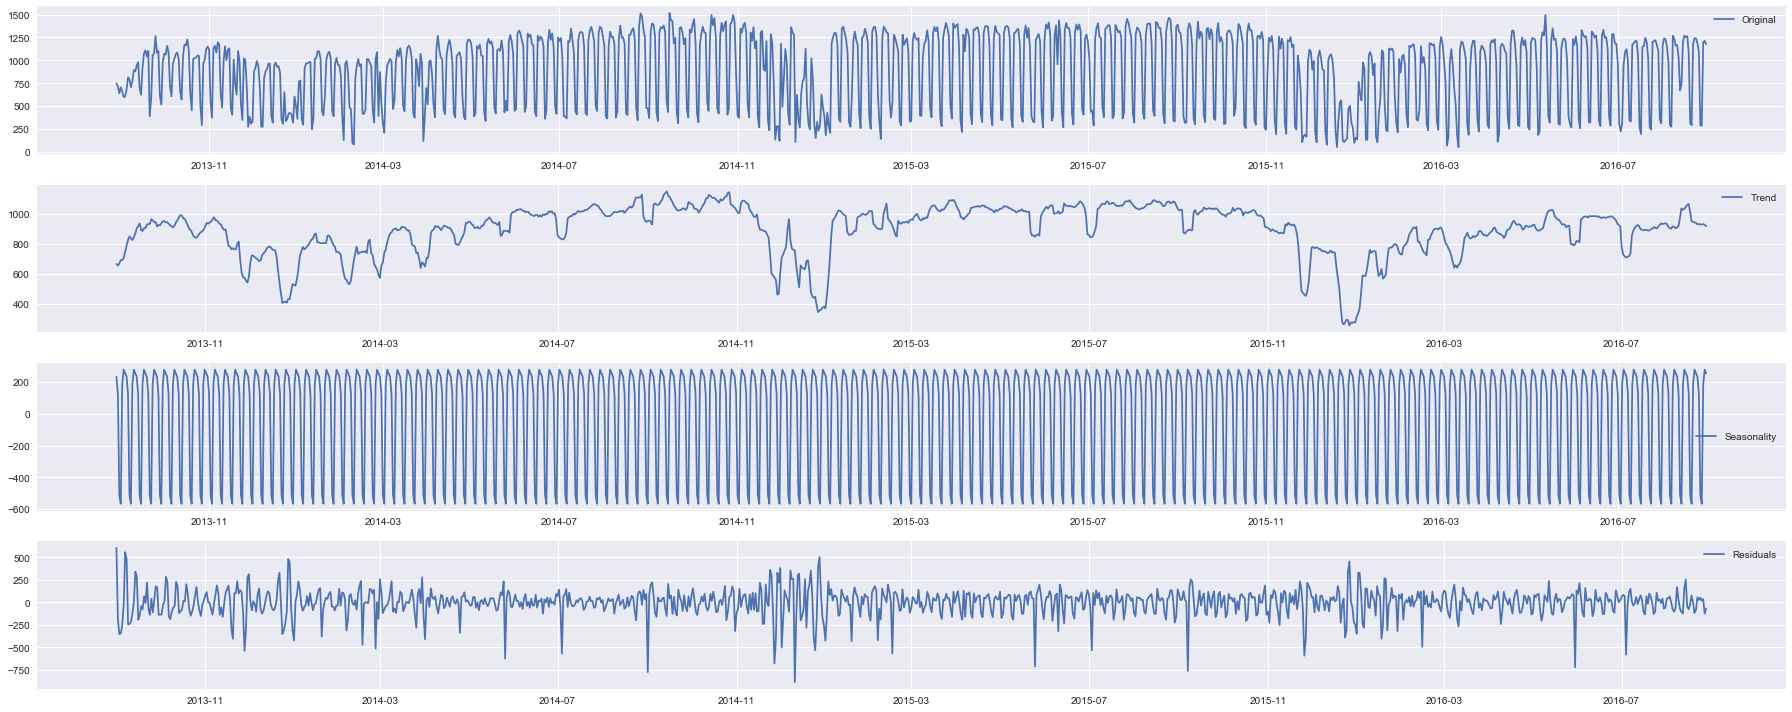

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(tDDemand)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(tDDemand, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

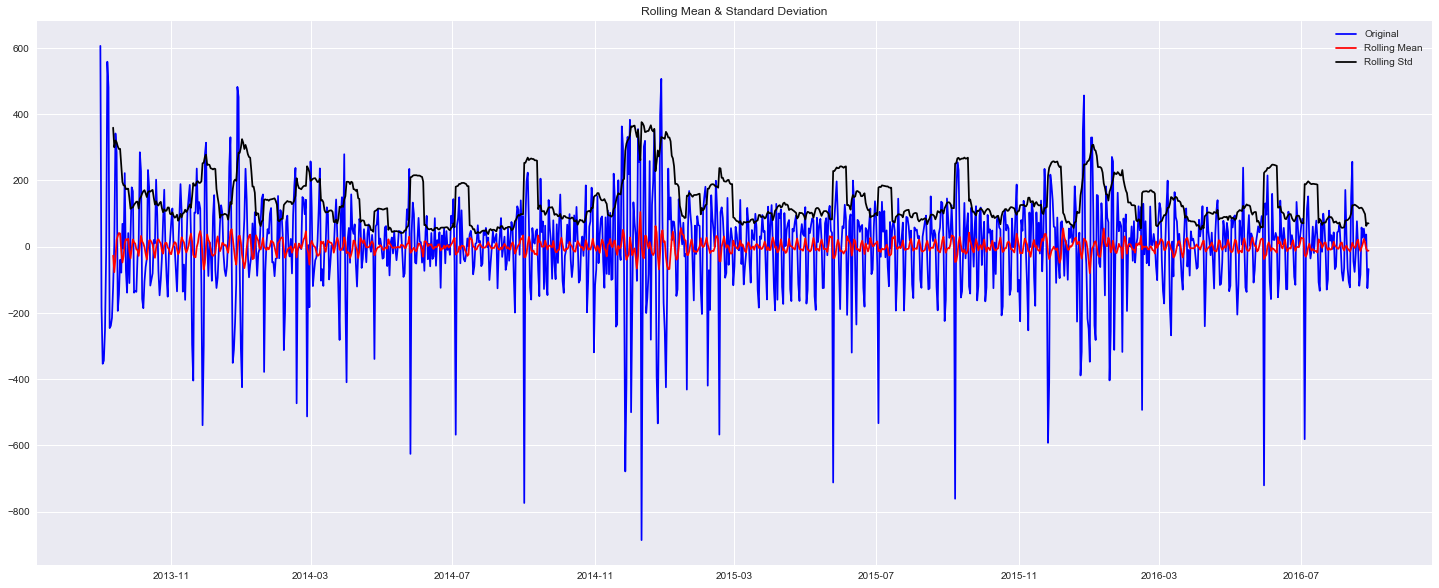

Results of Dickey-Fuller Test:
Test Statistic                -1.493906e+01
p-value                        1.331025e-27
#Lags Used                     1.900000e+01
Number of Observations Used    1.073000e+03
Critical Value (1%)           -3.436459e+00
Critical Value (5%)           -2.864237e+00
Critical Value (10%)          -2.568206e+00
dtype: float64


In [39]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

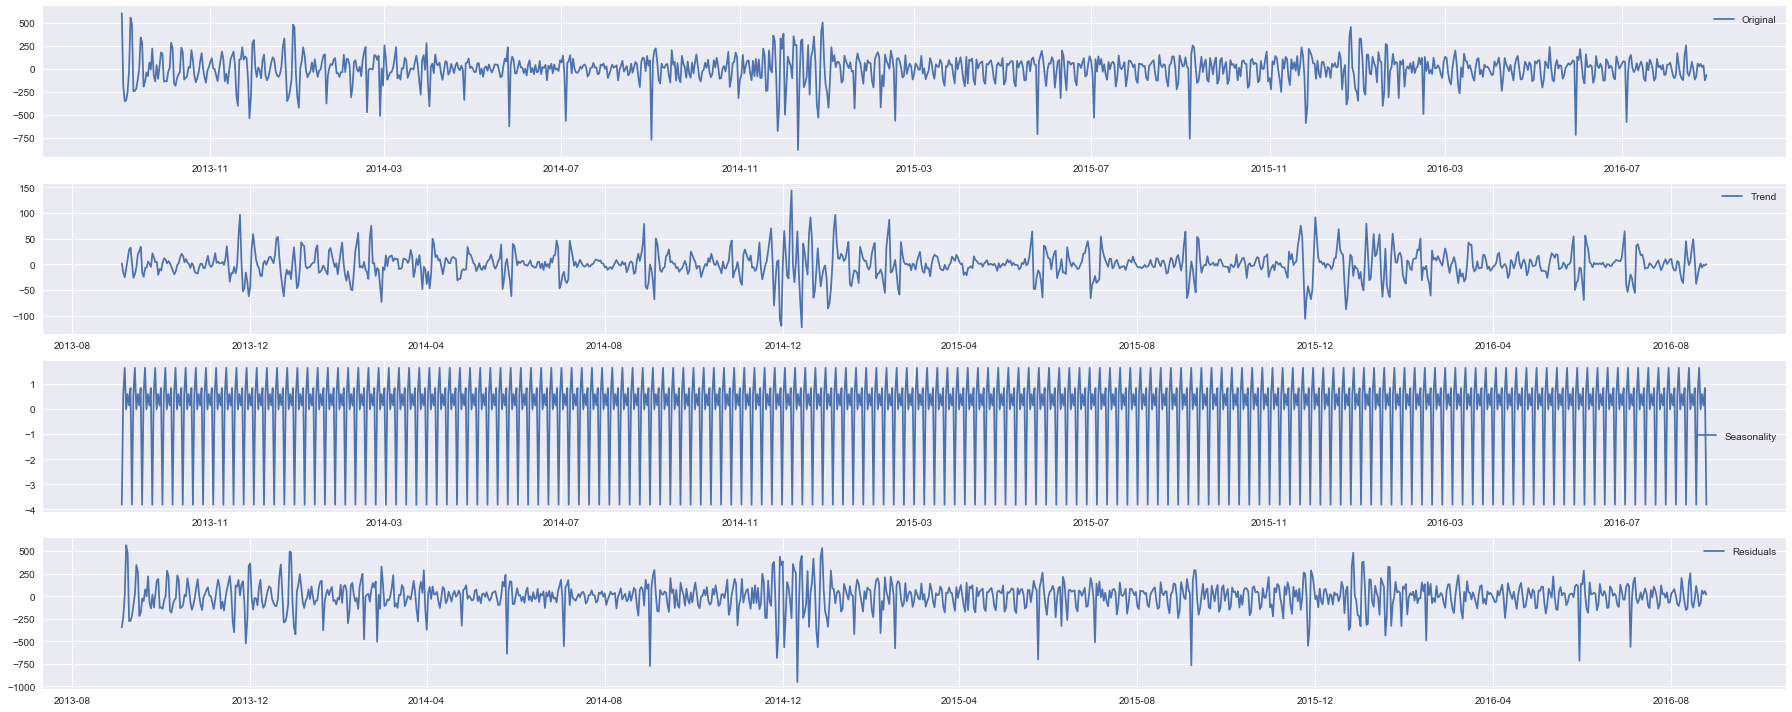

In [43]:
decomposition2 = seasonal_decompose(residual)
trend2 = decomposition2.trend
seasonal2 = decomposition2.seasonal
residual2 = decomposition2.resid

plt.subplot(411)
plt.plot(residual, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

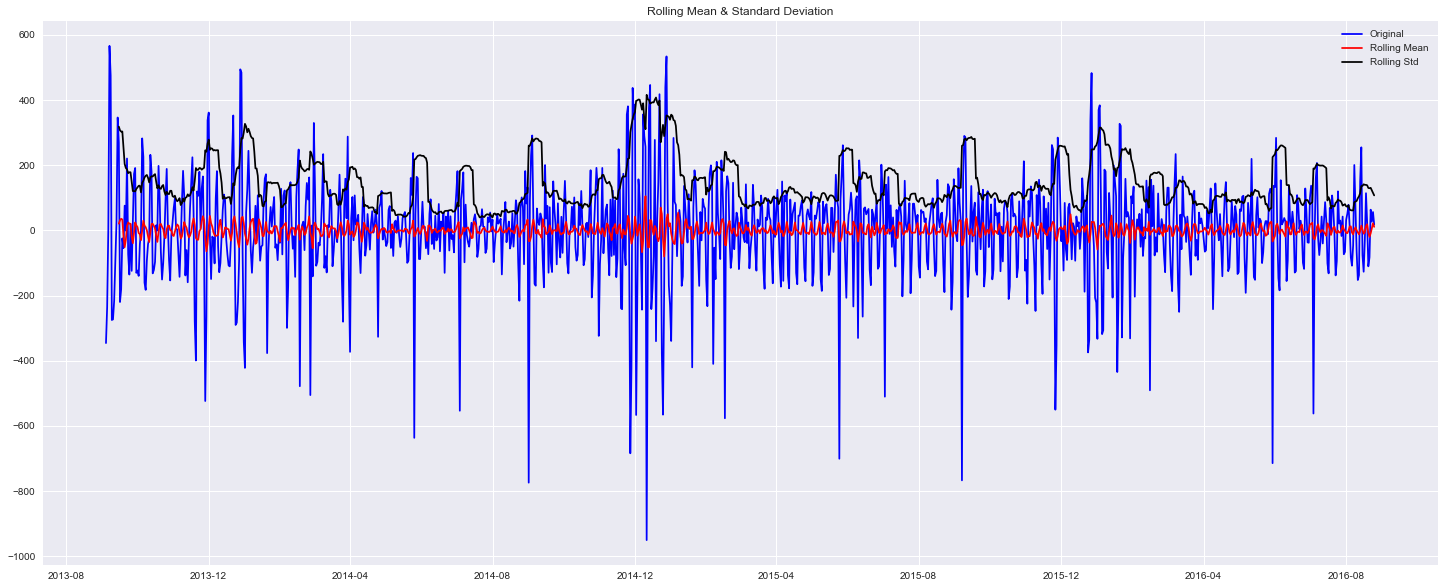

Results of Dickey-Fuller Test:
Test Statistic                  -19.872804
p-value                           0.000000
#Lags Used                       22.000000
Number of Observations Used    1064.000000
Critical Value (1%)              -3.436511
Critical Value (5%)              -2.864260
Critical Value (10%)             -2.568218
dtype: float64


In [44]:
ts_log_decompose2 = residual2
ts_log_decompose2.dropna(inplace=True)
test_stationarity(ts_log_decompose2)

In [48]:
tDDemand_Diff365 = tDDemand - tDDemand.shift(periods=364)

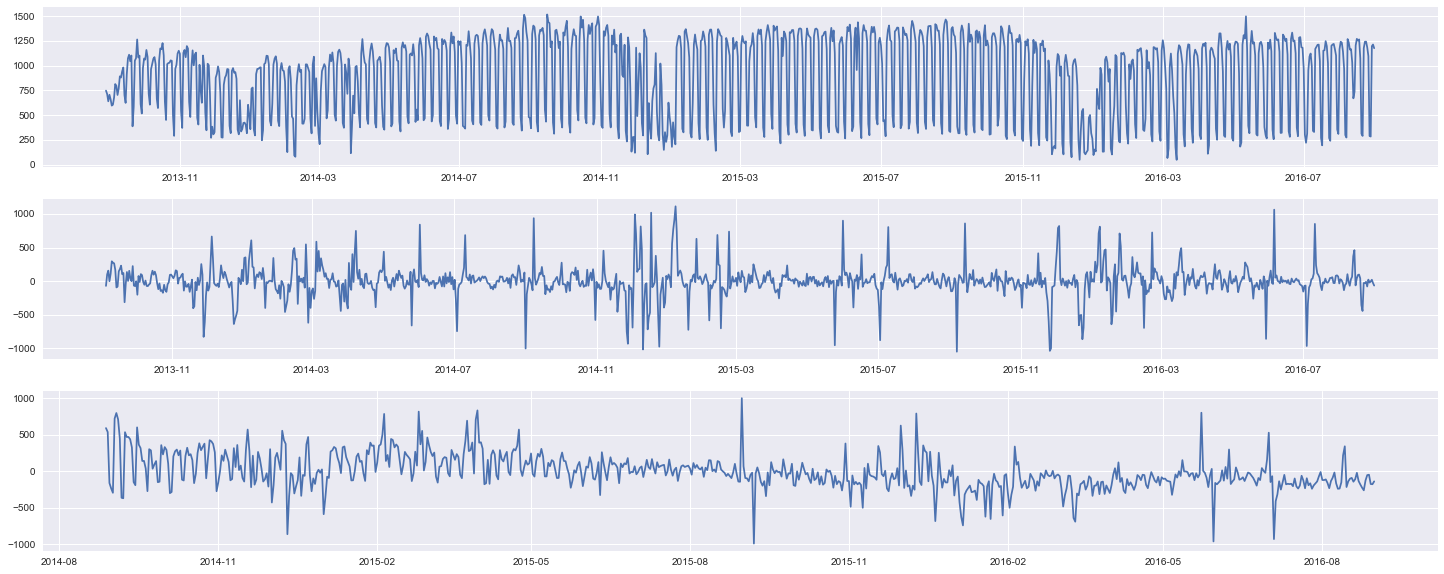

In [49]:
plt.subplot(311)
plt.plot(tDDemand)
plt.subplot(312)
plt.plot(tDDemand-tDDemand.shift(periods=7))
plt.subplot(313)
plt.plot(tDDemand_Diff365)


In [50]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [51]:
lag_acf = acf(tDDemand, nlags=20)
lag_pacf = pacf(tDDemand, nlags=20, method='ols')

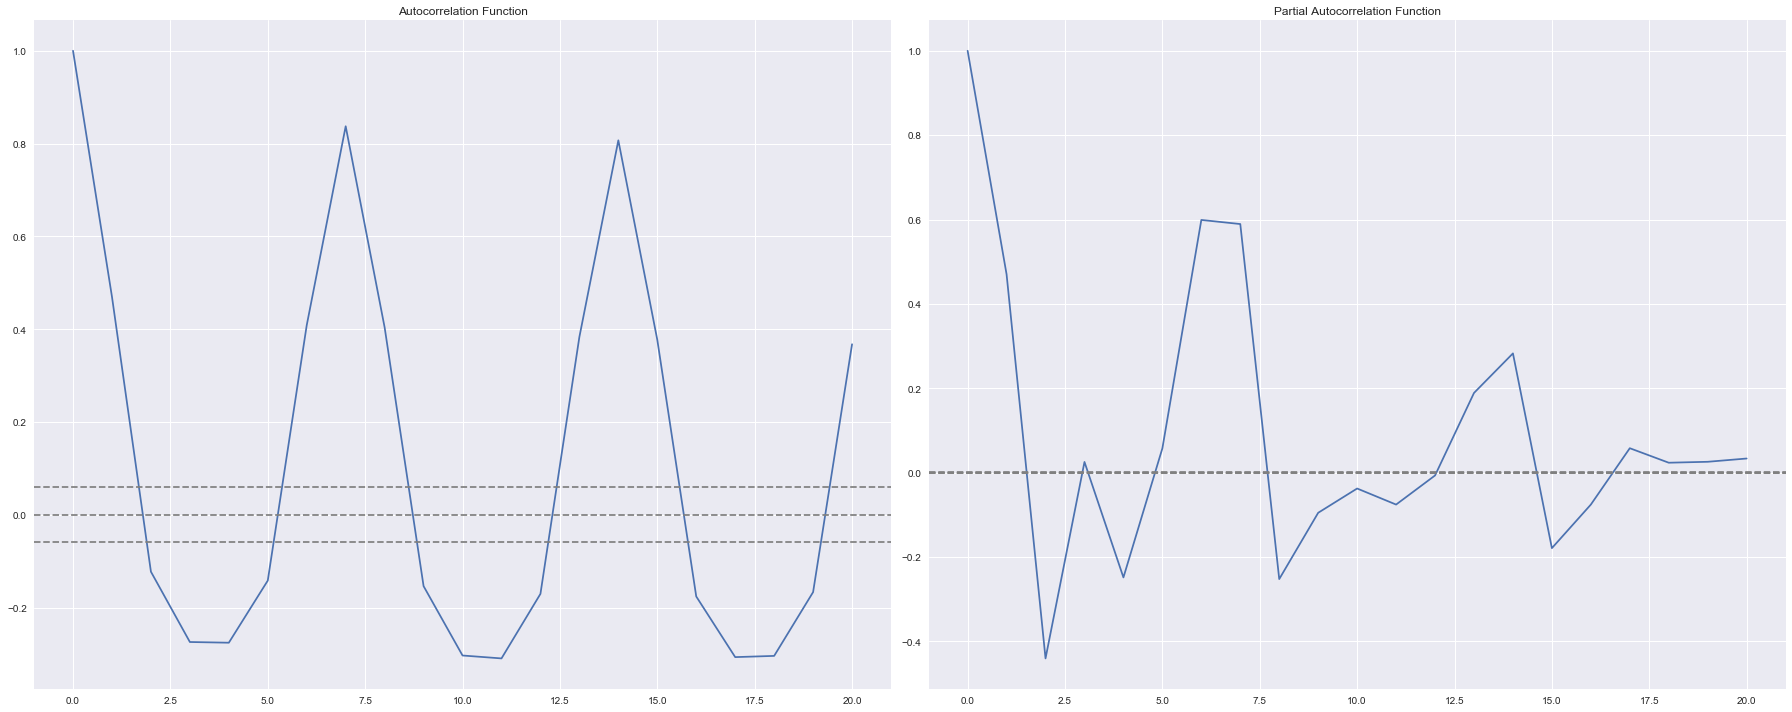

In [53]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tDDemand)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tDDemand)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tDDdemand)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tDDdemand)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [54]:
from statsmodels.tsa.arima_model import ARIMA

In [56]:
model = ARIMA(tDDemand, order=(2, 1, 0))  
results_AR = model.fit(disp=5)  
plt.plot(tDDemand)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-tDDemand)**2))

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'